# Introduction

**This Project for Natural Language Processing / Machine Learning Courses in Benha Faculty of Computers & AI - Egypt**

   Welcome to this notebook, This notebook is about implementing Sentiment Analysis on English Voiced-Text, thanks for using [Sentiment dataset with 1 million tweets](https://free-electronic.com/product/arduino-pro-micro-atmega32u4/) & [Youtube Statistics Dataset](https://www.kaggle.com/datasets/advaypatil/youtube-statistics/versions/1) .

   Both datasets are used for the variations of Positive & Negative expressions for different situations on social media, whether it is a *feedback*, *expressing feelings*, discussions and lot more, and that's obviously is easy with today **SOCIAL MEDIA**.
   
   nowadays, there are many efforts to make controlling machines easier, i.e. controlling machines with voice instead of typing some shell commands, even sharing your own feelings with voice instead of typing some words, express your feedback as much as you want !
   
   **TO DEFINE IT MORE CLEARLY,** our problem is to Analyize (Classify) the sentiment of our English Voiced-Text if it is Positive or Negative, which is *Binary Classification*
   
   ***Through this Notebook you will face:***
* Data Gathering & Exploratory Data Analysis
* Data Preparation & Cleaning
* Data Preprocessing
* Data Representation & Vectorization
* Modeling & Training
* Evaluation & Comparison
* Trying & Testing
* Deployment

![](https://imageio.forbes.com/specials-images/imageserve/61c4dab3dcce70ad2cdf606a/0x0.jpg?format=jpg&width=1200)

# 1. Setup the notebook

## 1.1 Loading Required Libraries

In [100]:
#Importing all Important Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import gensim
import nltk
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import seaborn as sns
from plotly import graph_objs as go
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!


## 1.2 Defining the paths to the datasets

In [101]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/youtube-statistics/videos-stats.csv
/kaggle/input/youtube-statistics/comments.csv
/kaggle/input/sentiment-dataset-with-1-million-tweets/dataset.csv


# 2. Data Gathering & Exploratory Data Analysis

## 2.1 Getting the datasets into work

In [102]:
# Start reading the datasets from the specified paths
youtube_comments = pd.read_csv('/kaggle/input/youtube-statistics/comments.csv')
sentiment_tweets = pd.read_csv('/kaggle/input/sentiment-dataset-with-1-million-tweets/dataset.csv')

## 2.2 Getting youtube statistics dataset

In [103]:
youtube_comments.head()

Unnamed: 0     Video ID                                            Comment  \
0           0  wAZZ-UWGVHI  Let's not forget that Apple Pay in 2014 requir...   
1           1  wAZZ-UWGVHI  Here in NZ 50% of retailers don’t even have co...   
2           2  wAZZ-UWGVHI  I will forever acknowledge this channel with t...   
3           3  wAZZ-UWGVHI  Whenever I go to a place that doesn’t take App...   
4           4  wAZZ-UWGVHI  Apple Pay is so convenient, secure, and easy t...   

   Likes  Sentiment  
0   95.0        1.0  
1   19.0        0.0  
2  161.0        2.0  
3    8.0        0.0  
4   34.0        2.0

I'll try to bar the number of samples for each sentiment, note that **0, 1, 2 for Negative, Neutral and Positive Sentiments** respectively.
> Sentiment: The sentiment of the comment. A value of 0 represents a negative sentiment, while values of 1 or 2 represent neutral and positive sentiments respectively.

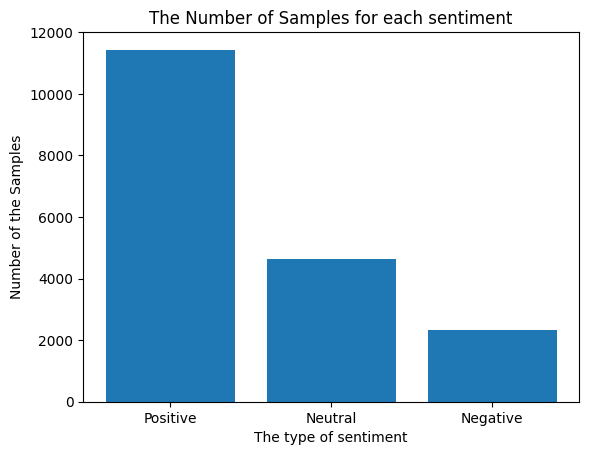

In [104]:
counting = youtube_comments.Sentiment.value_counts()
plt.bar(['Positive', 'Neutral', 'Negative'],counting)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of Samples for each sentiment")
plt.show()

Since our problem is *Binary Classification* , i'll drop the **Neutral Sentiment** , there is no need for this class at our problem .

In [105]:
# Getting ONLY the Comment & Sentiment columns for further processing
First_corpus = pd.DataFrame(columns=['Text','Label'])
First_corpus['Text'],First_corpus['Label'] = youtube_comments['Comment'],youtube_comments['Sentiment']

In [106]:
# Dropping the Neutral Sentiment rows, and assign the Positive class (2.0) to (1.0) instead
First_corpus.drop(First_corpus[First_corpus['Label'] == 1.0].index, inplace=True)
First_corpus.loc[First_corpus['Label'] == 2.0, 'Label'] = 1.0

## 2.3 Analyzing youtube statistics dataset

In [107]:
First_corpus.head(10)

Text  Label
1   Here in NZ 50% of retailers don’t even have co...    0.0
2   I will forever acknowledge this channel with t...    1.0
3   Whenever I go to a place that doesn’t take App...    0.0
4   Apple Pay is so convenient, secure, and easy t...    1.0
6   We only got Apple Pay in South Africa in 2020/...    1.0
8   In the United States, we have an abundance of ...    1.0
10  Wow, you really went to town on the PSU test r...    1.0
11  The lab is the most exciting thing in IT I've ...    1.0
12  Linus, I'm an engineer and love the LMG conten...    1.0
13  There used to be a time where Linus was the sm...    1.0

In [108]:
First_corpus.Text.describe()

count                                                 13770
unique                                                13462
top       One of the best thing about Dude is that he\r\...
freq                                                     10
Name: Text, dtype: object

It shows that there is some **DUPLICATED TEXTS** which is there is no need for them, they will be dropped .

In [109]:
First_corpus.drop_duplicates(inplace=True)
print(First_corpus.Text.is_unique)
print(f'Number of Samples after removing duplication: {len(First_corpus)}')

True
Number of Samples after removing duplication: 13462


looks good now ! now trying to drop null values/texts if any .

In [110]:
First_corpus.dropna(inplace=True)
print(f'Number of Samples after removing null values: {len(First_corpus)}')

Number of Samples after removing null values: 13462


There is no Null values in the text, which is good indicator , so our dataset is READY FOR THE NEXT STAGE ***DATA CLEANING & PREPARATION***

## 2.4 Getting sentiment dataset with 1 million tweets

In [111]:
sentiment_tweets.head()

Text Language      Label
0  @Charlie_Corley @Kristine1G @amyklobuchar @Sty...       en  litigious
1  #BadBunny: Como dos gotas de agua: Joven se di...       es   negative
2  https://t.co/YJNiO0p1JV Flagstar Bank disclose...       en  litigious
3  Rwanda is set to host the headquarters of Unit...       en   positive
4  OOPS. I typed her name incorrectly (today’s br...       en  litigious

It is a little bit different here about this dataset ! since the dataset is divided into **Language-based** texts, the *Non-English* texts will be dropped for our problem .

In [112]:
# Dropping Non-English texts from the datasets
print(f"The number of samples before dropping Non-English texts: {len(sentiment_tweets)}")
sentiment_tweets = sentiment_tweets[sentiment_tweets['Language'] == 'en']
print(f"The number of samples AFTER dropping Non-English texts: {len(sentiment_tweets)}")

The number of samples before dropping Non-English texts: 937854
The number of samples AFTER dropping Non-English texts: 871310


looks like the subset of the dataset  (*English Texts*) is HUGE ! that's actually true and referred in the [Dataset Card](https://www.kaggle.com/datasets/tariqsays/sentiment-dataset-with-1-million-tweets) .

Let's see how the Sentiments looks like ...

**Note !** the dataset contains *4 SENTIMENTS CATEGORIES* {Positive, Negative, Litigious, Uncertainty}
> The tweets have been annotated with 4 different categories(positive,negative,uncertainty,litigious) and they can be used to detect sentiment . 

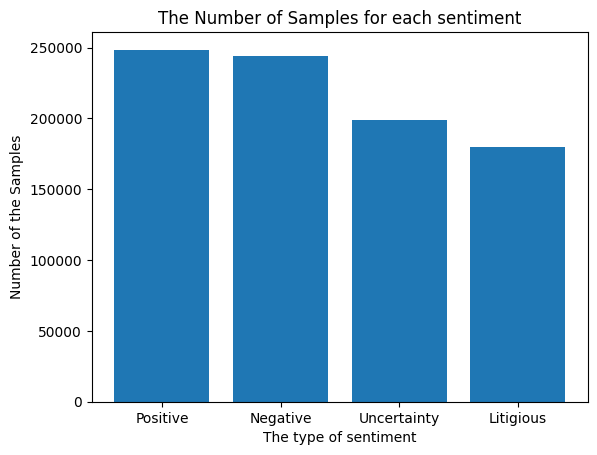

In [113]:
counting = sentiment_tweets.Label.value_counts()
plt.bar(['Positive','Negative','Uncertainty','Litigious'],counting)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of Samples for each sentiment")
plt.show()

As mentioned before, there is no need for any other sentiment category than {Positive, Negative}, so the others will be dropped .

In [114]:
# Labelling the Positive and Negative Classes into 1.0 & 0.0 respectively
Second_corpus = pd.DataFrame(columns=['Text','Label'])
sentiment_tweets = sentiment_tweets[sentiment_tweets['Language'] == 'en']
sentiment_tweets.loc[sentiment_tweets['Label'] == 'positive','Label'] = 1.0
sentiment_tweets.loc[sentiment_tweets['Label'] == 'negative','Label'] = 0.0

# Dropping the other Classes
print(f'The number of samples before dropping: {len(sentiment_tweets)}')
sentiment_tweets.drop(sentiment_tweets[(sentiment_tweets['Label'] == 'uncertainty') | (sentiment_tweets['Label'] == 'litigious')].index
                     ,inplace=True)
print(f'The number of samples AFTER dropping: {len(sentiment_tweets)}')
# Getting only Text & Label columns
Second_corpus['Text'] , Second_corpus['Label'] = sentiment_tweets['Text'] , sentiment_tweets['Label']

The number of samples before dropping: 871310
The number of samples AFTER dropping: 492662


## 2.5 Analyzing the tweets sentiments dataset

In [115]:
Second_corpus.head(10)

Text Label
3   Rwanda is set to host the headquarters of Unit...   1.0
5   It sucks for me since I'm focused on the natur...   0.0
8   Social Security. Constant political crises dis...   0.0
9   @FilmThePoliceLA A broken rib can puncture a l...   0.0
10  @jacobringenwald @aKeithWatts @CountDankulaTV ...   0.0
11  @NZ_HK_SU @telebusiness My question was rhetor...   0.0
12  Wimbledon: Nick Kyrgios admits spitting toward...   1.0
13  is booktwt a thing? if so thats her and she sp...   1.0
16  @roipaee @joe98100959 @Formula1game @redbullra...   0.0
17  🤩 Power back on (1855749):  North VI in Ladysm...   0.0

In [116]:
Second_corpus.Text.describe()

count                          492662
unique                         488600
top       @FlylightsTech Good project
freq                               73
Name: Text, dtype: object

As the same before, here are **DUPLICATED TEXTS** , it is time to remove it

In [117]:
Second_corpus.drop_duplicates(inplace=True)
print(f'Number of Samples after removing duplication: {len(Second_corpus)}')

Number of Samples after removing duplication: 490393


Now counting the **NULL VALUES IF EXIST** and try to drop them all .

In [118]:
Second_corpus.Text.isna().value_counts()

False    490393
Name: Text, dtype: int64

## 2.6 Getting them all Together

In [119]:
# Concatenating the First & Second corpuses into one df
df = pd.concat([First_corpus,Second_corpus],ignore_index=True)
print(df.Label.value_counts())
print(f'The number of total samples after concatenating: {len(df)}')
df.head(10)

1.0    258395
0.0    245460
Name: Label, dtype: int64
The number of total samples after concatenating: 503855


Text Label
0  Here in NZ 50% of retailers don’t even have co...   0.0
1  I will forever acknowledge this channel with t...   1.0
2  Whenever I go to a place that doesn’t take App...   0.0
3  Apple Pay is so convenient, secure, and easy t...   1.0
4  We only got Apple Pay in South Africa in 2020/...   1.0
5  In the United States, we have an abundance of ...   1.0
6  Wow, you really went to town on the PSU test r...   1.0
7  The lab is the most exciting thing in IT I've ...   1.0
8  Linus, I'm an engineer and love the LMG conten...   1.0
9  There used to be a time where Linus was the sm...   1.0

The distribution of the dataset classes {Positive, Negative} will be examined, *if the data is imbalanced*, an technique will be applied to override this .

In [120]:
labels = df.groupby(df['Label']).size().index
values = df.groupby(df['Label']).size().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6,title='Distribution of Classes in the dataset')])
fig.show()

Looks like the Dataset is **BALANCED** so, NOW WE ARE READY FOR THE NEXT STAGE !

# 3. Data Preparation & Cleaning

In [121]:
# Trying to remove any duplication & null values after concatenating
print(f"The total number of samples {len(df)}")
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print(f"The total number of samples after dropping some {len(df)}")

The total number of samples 503855
The total number of samples after dropping some 503855


It is expected to face some troubles using Social Media comment & tweets for training, which is the dataset may contains:

1. **Mentions @**

2. **Hashtags #**

3. **Emojies and Flags**

4. **Links & URLs**

5. **Symbols**

6. **Digits which is useless at our problem**

7. **Duplicated characters within the same word**

8. **Abbreviations**

***It is all useless for our problem***

In [122]:
# Defining a function that remove 1-7
def cleaning(text):
    text = re.sub(r'#\w+','', text)                 # Removing Hashtags
    text = re.sub(r'http\S+','', text)              # Removing Links & URLs
    text = re.sub(r'@\w+','', text)                 # Removing Mentions
    text = re.sub('[()!?.\';:<>`$%’,]', '', text)   # Removing Punctuations with different forms
    text = re.sub(r'[^a-zA-Z]',' ', text)           # Removing digits
    text = re.sub(r'([a-zA-Z])\1{2,}','\1', text)   # Reduce duplicated character (> 3) to only one
    return text

# Defining list of Abbreviations to be expanded to its original form
abbreviations = {'fyi': 'for your information',
                 'lol': 'laugh out loud',
                 'loza': 'laughs out loud',
                 'lmao': 'laughing',
                 'rofl': 'rolling on the floor laughing',
                 'vbg': 'very big grin',
                 'xoxo': 'hugs and kisses',
                 'xo': 'hugs and kisses',
                 'brb': 'be right back',
                 'tyt': 'take your time',
                 'thx': 'thanks',
                 'abt': 'about',
                 'bf': 'best friend',
                 'diy': 'do it yourself',
                 'faq': 'frequently asked questions',
                 'fb': 'facebook',
                 'idk': 'i don\'t know',
                 'asap': 'as soon as possible',
                 'syl': 'see you later',
                 'nvm': 'never mind',
                 'frfr':'for real for real',
                 'istg':'i swear to god',
    }

In [123]:
# Putting all together
def DataCleaning(corpus):
    corpus['Text'] = corpus['Text'].apply(cleaning)     # Calling cleaning function (1-7)
    corpus['Text'] = corpus['Text'].str.lower()         # Normalize all characters to lowercase
    for abbreviation, full_form in abbreviations.items(): # Expanding the Abbreviations
        corpus['Text'] = corpus['Text'].str.replace(abbreviation, full_form)
    return corpus

In [124]:
df = DataCleaning(df)

In [125]:
print(f"The total number of samples: {len(df)}")
df.drop_duplicates(inplace=True)                # Dropping duplicated texts if exist after Cleaning
df.dropna(inplace=True)                         # Dropping Null values if exist after Cleaning
print(f"The total number of samples after removal: {len(df)}")

The total number of samples: 503855
The total number of samples after removal: 483998


In [126]:
df.Text.describe()

count                                                483998
unique                                               482185
top       none of the innovation can even solve the prob...
freq                                                      2
Name: Text, dtype: object

Using **WordCloud** the most frequent words at *The whole dataset, for positive class and for the negative class* will be shown .

(-0.5, 1999.5, 1599.5, -0.5)

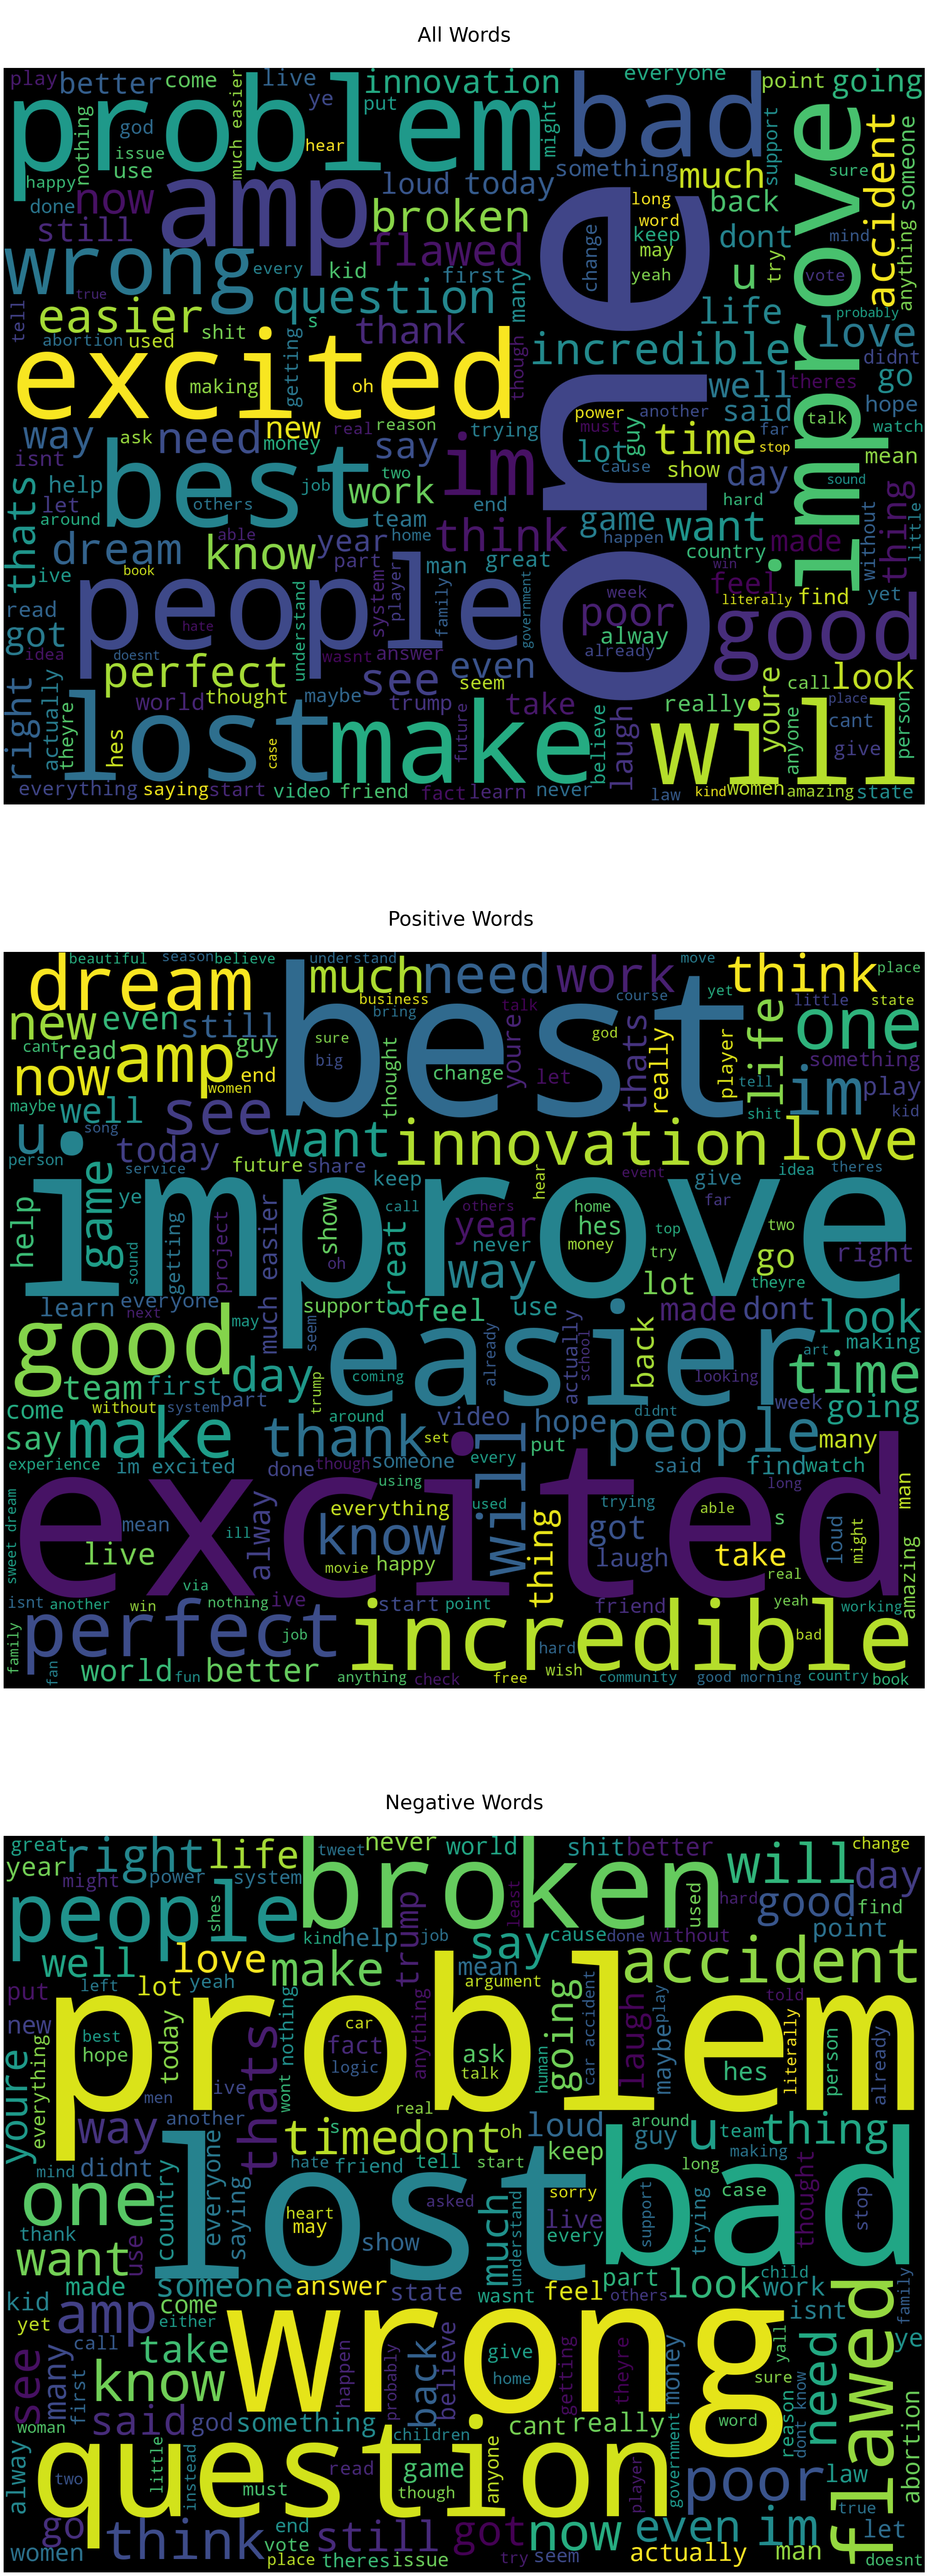

In [127]:
fig, ax = plt.subplots(3, 1, figsize  = (90,90))
all_words = WordCloud(
                          background_color='black',
                          width=2000,
                          height=1600
                         ).generate(' '.join(df['Text']))

positive_words =WordCloud(
                          background_color='black',
                          width=2000,
                          height=1600
                         ).generate(" ".join(df[df['Label']==1.0]['Text']))

negative_words =WordCloud(
                          background_color='black',
                          width=2000,
                          height=1600
                         ).generate(" ".join(df[df['Label']==0.0]['Text']))

ax[0].imshow(all_words)
ax[0].set_title('\nAll Words\n', fontsize=40)
ax[0].axis('off')
print('\n')
ax[1].imshow(positive_words)
ax[1].set_title('\nPositive Words \n',fontsize=40)
ax[1].axis('off')
print('\n')
ax[2].imshow(negative_words)
ax[2].set_title('\nNegative Words\n',fontsize=40)
ax[2].axis('off')

# 4. Data Preprocessing

## 4.1 Removing Stop Words

Since the stopwords has no effect at our problem, it will be removed using **remove_stopwords function from gensim library (for wide range of stop words)**

In [128]:
df['Text'] = df['Text'].apply(remove_stopwords)

## 4.2 Tokenization

Basic tokenization will be applied to the dataset, **Using word_tokenize from nltk library**

In [129]:
df['Tokenized'] = df['Text'].apply(word_tokenize)

## 4.3 Lemmatization with POS

Using lemmatization technique with Part-of-Speech (POS) to reduce the words to its original form, depend on the where the word is !

This technique especially to make sure that every word is reduced to its equivalent correct form, rather than using Normal Lemmatization .

In [130]:
# Defining all Required Paramaters for WordNet Lemmatizer (POS Tags Reducing - POS Tagging)
lemmatizer = WordNetLemmatizer()
# pos_tagger function to Reduce Nouns to N, Adjectives to J ... etc , for further processing
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def lemmatization(text):
    new_sen = []
    pos_tagged = pos_tag(text)
    wordnet_tagged = list(map(lambda x: (x[0],pos_tagger(x[1])), pos_tagged)) # POS Tagging & Reducing
    for word, tag in wordnet_tagged:
        if tag is None:
            new_sen.append(word)
        else:
            new_sen.append(lemmatizer.lemmatize(word,tag))                   # Lemmatizing
            
    return new_sen

In [131]:
# Lemmatizing the Corpus
df['Tokenized'] = df['Tokenized'].apply(lemmatization)

In [132]:
# Regrouping the Words into sentences to detect if there is any duplication or Null Values
df['Text'] = df['Tokenized'].apply(lambda x: " ".join(x))
print(f"The total number of samples: {len(df)}")
df.Text.drop_duplicates(inplace=True)
df.Text.dropna(inplace=True)
print(f"The total number of samples after dropping: {len(df)}")

The total number of samples: 483998
The total number of samples after dropping: 483998


The dataset now is ready to be vectorized (**NEXT STAGE**)

# 5. Data Representation & Vectorization

## 5.1 TF-IDF Vectorization

For our problem, i.e. Sentiment Analysis & Classification, the most appropriate representation would be TF-IDF Vectorizer, it provide more accurate correlation between words (Features) and how they are appeard within the whole corpus.

> The results of this work show that calculating the TF-IDF score of the corpus allows for a more accurate representation of the overall polarity since terms are given a weight based on their uniqueness and relevance rather than just the frequency at which they appear in the corpus.

[Sentiment Analysis on Twitter Data Using Term Frequency-Inverse Document Frequency](https://www.scirp.org/journal/paperinformation.aspx?paperid=119519)

In [133]:
# For more accurate vectorizing, the Vectorizer has specified as the following
# strip_accents: if any symbols/emojies or any character that is not encoded in ASCII will be removed
# analyzer: the tokenization process will be re-applied as words -if chars are detected will not be taken-
# smooth_idf: later in evaluation/testing, if any word doesn't exist, then the denominator of the
# TF-IDF Calculation will be 1 -to avoid dividing on zero-
# min_df: to skip any word that document frequency is less than 10 which means has less effect

vectorizer = TfidfVectorizer(strip_accents='ascii',analyzer='word',
                            smooth_idf=True, norm=None, min_df=10)
X = vectorizer.fit_transform(df['Text'])
y = df['Label'].astype('Int64')                       # To split labels and convert it to Int type

In [134]:
# To see the properties, features of the Vector X
print("The shape of the dataset:", X.shape)
print("Some of the vocabulary: ", list(vectorizer.vocabulary_.items())[:10])

The shape of the dataset: (483998, 20958)
Some of the vocabulary:  [('nz', 12830), ('retailer', 15637), ('dont', 5376), ('contactless', 3823), ('credit', 4142), ('card', 2692), ('machine', 11135), ('like', 10781), ('pay', 13610), ('wave', 20279)]


There are 20958 features which is still huge number of features at the Vocabulary, it can be reduced in the Next Stage

# 6. Modeling & Training

## 6.1 Splitting data for Training & Testing

In [135]:
# The training size will be 70% and test size is 30%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, shuffle=True, random_state=41)

In [136]:
# We will use some metrics to compare the evaluation performance of the models later
result = pd.DataFrame(columns=['Model Name','Accuracy','Precision Score','Recall Score','F1-Score'])

## 6.2 Random Forest Classifier
The hyperparameters will be tuning in order to get the best number of n_estimator that could affects the accuracy

In [137]:
# Hyperparameter Tuning for n_estimator to Random Forest Classifier
t_result = []
for i in range(1,11):
    RF = RandomForestClassifier(n_estimators=i, criterion='entropy', n_jobs=-1)
    RF.fit(X_train,y_train)
    prediction = RF.predict(X_train)
    t_result.append((i,accuracy_score(y_train,prediction), precision_score(y_train,prediction), 
                    recall_score(y_train,prediction), f1_score(y_train,prediction)))

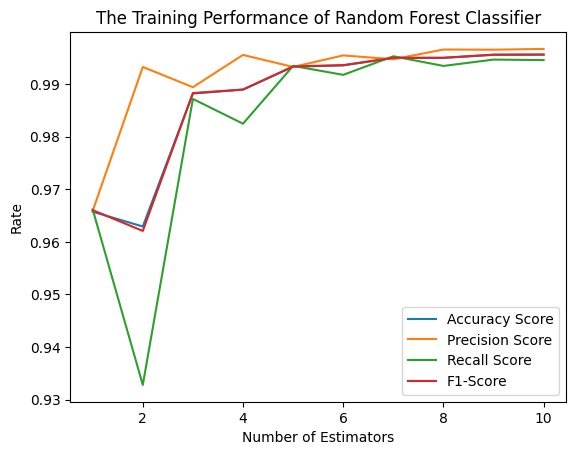

In [138]:
# Plotting the Training Performance
result_df = pd.DataFrame(t_result, columns=['num. of estimator', 'Accuracy', 'Precision','Recall',
                                          'F1-score'])
plt.plot(result_df['num. of estimator'], result_df['Accuracy'], label = 'Accuracy Score')
plt.plot(result_df['num. of estimator'], result_df['Precision'], label = 'Precision Score')
plt.plot(result_df['num. of estimator'], result_df['Recall'], label = 'Recall Score')
plt.plot(result_df['num. of estimator'], result_df['F1-score'], label = 'F1-Score')
plt.xlabel("Number of Estimators")
plt.ylabel("Rate")
plt.title("The Training Performance of Random Forest Classifier")
plt.legend()
plt.show()

In [139]:
# Training the RF on 10 estimator for best performance
RF = RandomForestClassifier(n_estimators= 10, criterion='entropy', n_jobs=-1)
RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=-1)

### 6.2.1 Evaluating the Random Forest Classifier and Save results

In [140]:
prediction = RF.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     72188
         1.0       0.98      0.96      0.97     73012

    accuracy                           0.97    145200
   macro avg       0.97      0.97      0.97    145200
weighted avg       0.97      0.97      0.97    145200



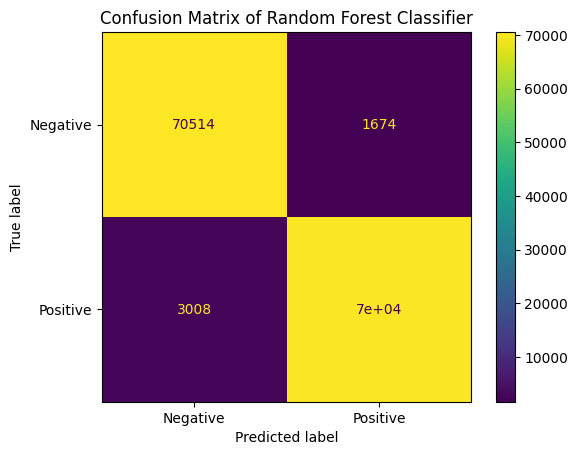

In [141]:
# Displaying the Confusion matrix of Random Forest Classifier
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Random Forest Classifier")
plt.show()

In [142]:
# Saving the evaluation Result of Random Forest Classifier
model_result = ['Random Forest Classifier',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

## 6.3 Logistic Regression
The hyperparameters will be tuning in order to get the best number of C Regularization that could affects the accuracy

In [143]:
# Hyperparameter Tuning for C regurlarization in order to get best training performance
t_result = []
itr = 0.1
while itr <= 1.00:
    LGR = LogisticRegression(penalty='l2', dual=False, C=itr, fit_intercept=True
                        , random_state = 41, solver = 'sag', max_iter=1000)
    LGR.fit(X_train, y_train)
    prediction = LGR.predict(X_train)
    t_result.append((itr,accuracy_score(y_train,prediction), precision_score(y_train,prediction), 
                    recall_score(y_train,prediction), f1_score(y_train,prediction)))
    itr += 0.1

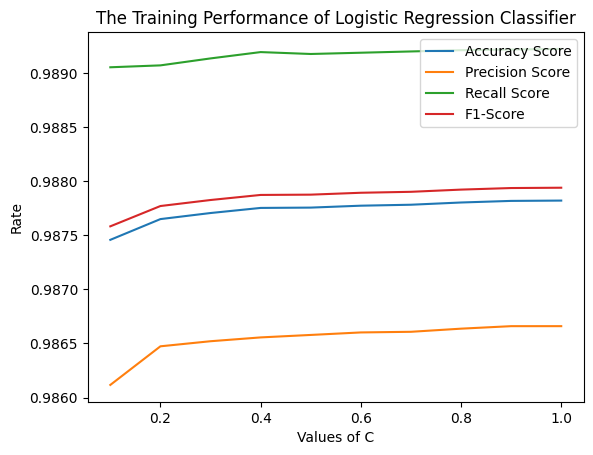

In [144]:
result_df = pd.DataFrame(t_result, columns=['C', 'Accuracy', 'Precision','Recall',
                                          'F1-score'])
plt.plot(result_df['C'], result_df['Accuracy'], label = 'Accuracy Score')
plt.plot(result_df['C'], result_df['Precision'], label = 'Precision Score')
plt.plot(result_df['C'], result_df['Recall'], label = 'Recall Score')
plt.plot(result_df['C'], result_df['F1-score'], label = 'F1-Score')
plt.xlabel("Values of C")
plt.ylabel("Rate")
plt.title("The Training Performance of Logistic Regression Classifier")
plt.legend()
plt.show()

In [145]:
# Training the Logistic Regression for C = 0.9 for best performance
LGR = LogisticRegression(penalty='l2', dual=False, C=0.9, fit_intercept=True
                        , random_state = 41, solver = 'sag', max_iter=1000)
LGR.fit(X_train, y_train)

LogisticRegression(C=0.9, max_iter=1000, random_state=41, solver='sag')

### 6.3.1 Evaluating The Logistic Regressions and Save Results

In [146]:
prediction = LGR.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     72188
         1.0       0.97      0.98      0.97     73012

    accuracy                           0.97    145200
   macro avg       0.97      0.97      0.97    145200
weighted avg       0.97      0.97      0.97    145200



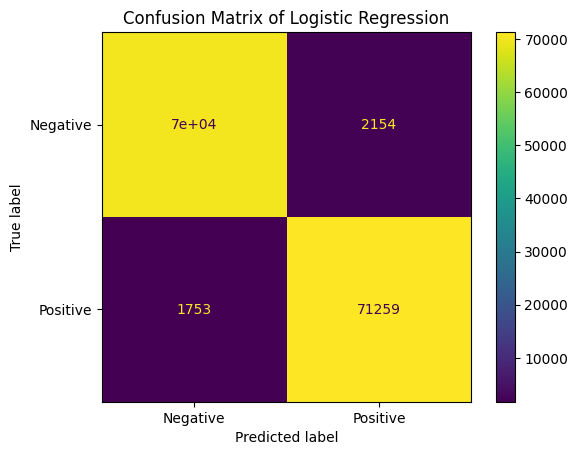

In [147]:
# Displaying the Confusion matrix of Logistic Regression
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

In [148]:
# Saving the evaluation Result of Logistic Regresion
model_result = ['Logistic Regression',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

## 6.4 Multinomial Naive Bayes

The Multinomial Naive Bayes will be used since it is suitable for TF-IDF counts, there is not too much parameters to adjust, so a basic MultinomialNB will be used .

> The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

[sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [149]:
NB = MultinomialNB()
NB.fit(X_train,y_train)

MultinomialNB()

In [150]:
print("\t\tThe Training Classification Report")
prediction = NB.predict(X_train)
print(classification_report(y_train,prediction))    # Display the Training Classification Report
print('\n')
print("\t\tThe Evaluation Classification Report")
prediction = NB.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

		The Training Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90    167950
         1.0       0.91      0.89      0.90    170848

    accuracy                           0.90    338798
   macro avg       0.90      0.90      0.90    338798
weighted avg       0.90      0.90      0.90    338798



		The Evaluation Classification Report
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     72188
         1.0       0.89      0.88      0.89     73012

    accuracy                           0.89    145200
   macro avg       0.89      0.89      0.89    145200
weighted avg       0.89      0.89      0.89    145200



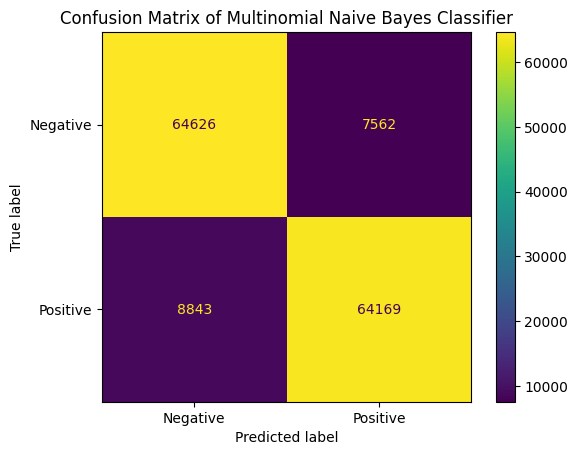

In [151]:
# Displaying the Confusion matrix of Multinomial Naive Bayes
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Multinomial Naive Bayes Classifier")
plt.show()

In [152]:
# Saving the evaluation Result of Multinomial Naive Bayes
model_result = ['MultinomialNB',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

## 6.5 Decision Tree Classifier

In [153]:
# basic hyperparameters is chosen for the DTClassifier, with entropy criterion
DT = DecisionTreeClassifier(criterion='entropy', max_features='sqrt')
DT.fit(X_train,y_train)
prediction = DT.predict(X_train)           # Training Performance will be measured

In [154]:
print("\t\tThe Training Classification Report")
prediction = DT.predict(X_train)
print(classification_report(y_train,prediction))    # Display the Training Classification Report
print('\n')
print("\t\tThe Evaluation Classification Report")
prediction = DT.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

		The Training Classification Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    167950
         1.0       1.00      0.99      1.00    170848

    accuracy                           1.00    338798
   macro avg       1.00      1.00      1.00    338798
weighted avg       1.00      1.00      1.00    338798



		The Evaluation Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     72188
         1.0       0.91      0.90      0.90     73012

    accuracy                           0.90    145200
   macro avg       0.90      0.90      0.90    145200
weighted avg       0.90      0.90      0.90    145200



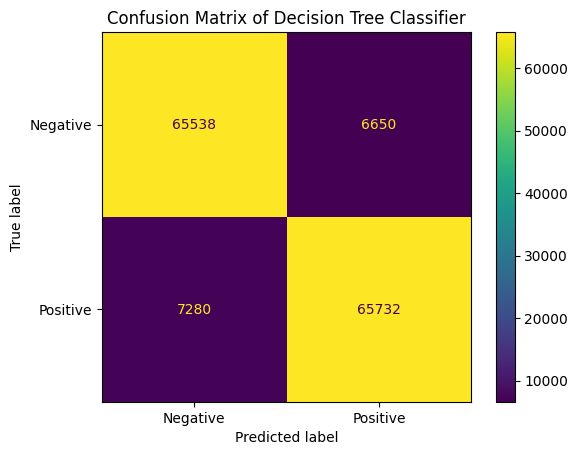

In [155]:
# Displaying the Confusion matrix of Decision Tree Classifier
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Decision Tree Classifier")
plt.show()

In [156]:
# Saving the evaluation Result of DecisionTreeClassifier
model_result = ['DecisionTree',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

## 6.6 Linear Support-Vector Classifier

As the same for Logistic Regression, the HyperParameter C will be tuned to get possible best result

In [157]:
# Hyperparameter Tuning for C regurlarization in order to get best training performance
t_result = []
itr = 0.1
while itr <= 1.00:
    LSVC = LinearSVC(penalty='l2',dual=False, C=itr)
    LSVC.fit(X_train,y_train)
    prediction = LSVC.predict(X_train)
    t_result.append((itr,accuracy_score(y_train,prediction), precision_score(y_train,prediction), 
                    recall_score(y_train,prediction), f1_score(y_train,prediction)))
    itr += 0.1

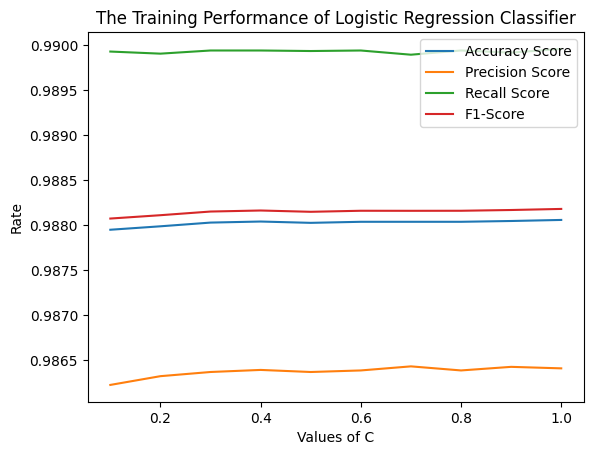

In [158]:
# Displaying the training performance
result_df = pd.DataFrame(t_result, columns=['C', 'Accuracy', 'Precision','Recall',
                                          'F1-score'])
plt.plot(result_df['C'], result_df['Accuracy'], label = 'Accuracy Score')
plt.plot(result_df['C'], result_df['Precision'], label = 'Precision Score')
plt.plot(result_df['C'], result_df['Recall'], label = 'Recall Score')
plt.plot(result_df['C'], result_df['F1-score'], label = 'F1-Score')
plt.xlabel("Values of C")
plt.ylabel("Rate")
plt.title("The Training Performance of Logistic Regression Classifier")
plt.legend()
plt.show()

Looks like it is Stable !

In [159]:
# Training the Linear SVC for C = 0.9 for best performance
LSVC = LinearSVC(penalty='l2',dual=False, C=0.9)
LSVC.fit(X_train,y_train)

LinearSVC(C=0.9, dual=False)

### 6.6.1 Evaluating The Linear Support-Vector Classifier and Save Results

In [160]:
prediction = LSVC.predict(X_test)
print(classification_report(y_test,prediction))    # Display the Testing Classification Report

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     72188
         1.0       0.96      0.97      0.96     73012

    accuracy                           0.96    145200
   macro avg       0.96      0.96      0.96    145200
weighted avg       0.96      0.96      0.96    145200



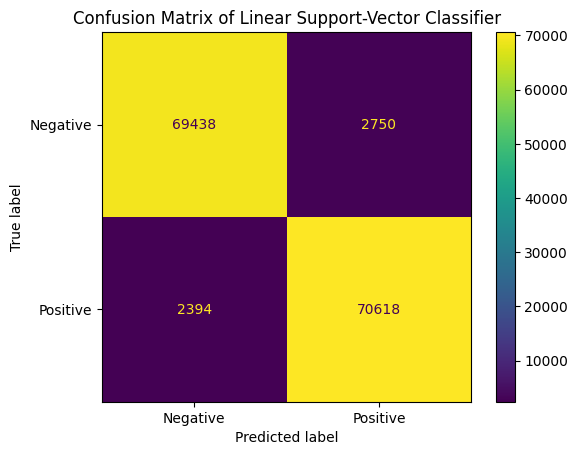

In [161]:
# Displaying the Confusion matrix of Linear SVC
cm_matrix = confusion_matrix(y_test,prediction)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Linear Support-Vector Classifier")
plt.show()

In [162]:
# Saving the evaluation Result of Linear SVC
model_result = ['Linear SVC',accuracy_score(y_test,prediction), 
              precision_score(y_test,prediction), recall_score(y_test,prediction),
              f1_score(y_test,prediction)]
result.loc[len(result)] = model_result

# 7. Evaluation & Comparison

In [163]:
# First, Displaying the DataFrame contains the Testing Performance of each Model
result

Model Name  Accuracy  Precision Score  Recall Score  F1-Score
0  Random Forest Classifier  0.967755         0.976646      0.958801  0.967641
1       Logistic Regression  0.973092         0.970659      0.975990  0.973317
2             MultinomialNB  0.887018         0.894578      0.878883  0.886661
3              DecisionTree  0.904063         0.908126      0.900290  0.904191
4                Linear SVC  0.964573         0.962518      0.967211  0.964859

## 7.1 Comparison based on Accuracy

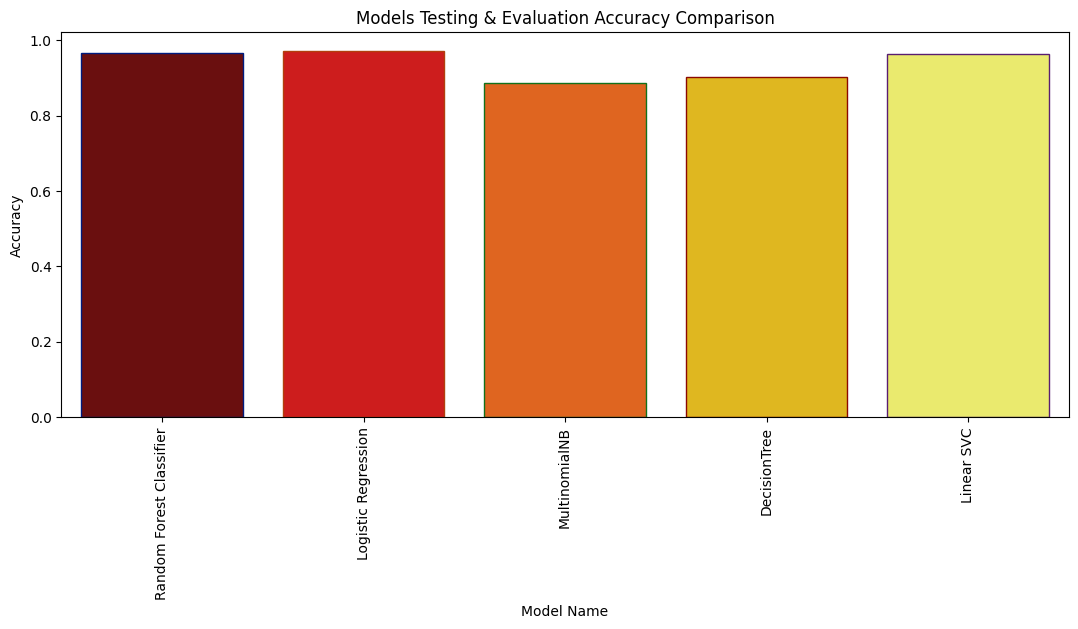

In [164]:
# Displaying a bar to compare between Models according to their Accuracy
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Accuracy",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Accuracy Comparison')
plt.show()

## 7.2 Comparison based on Precision

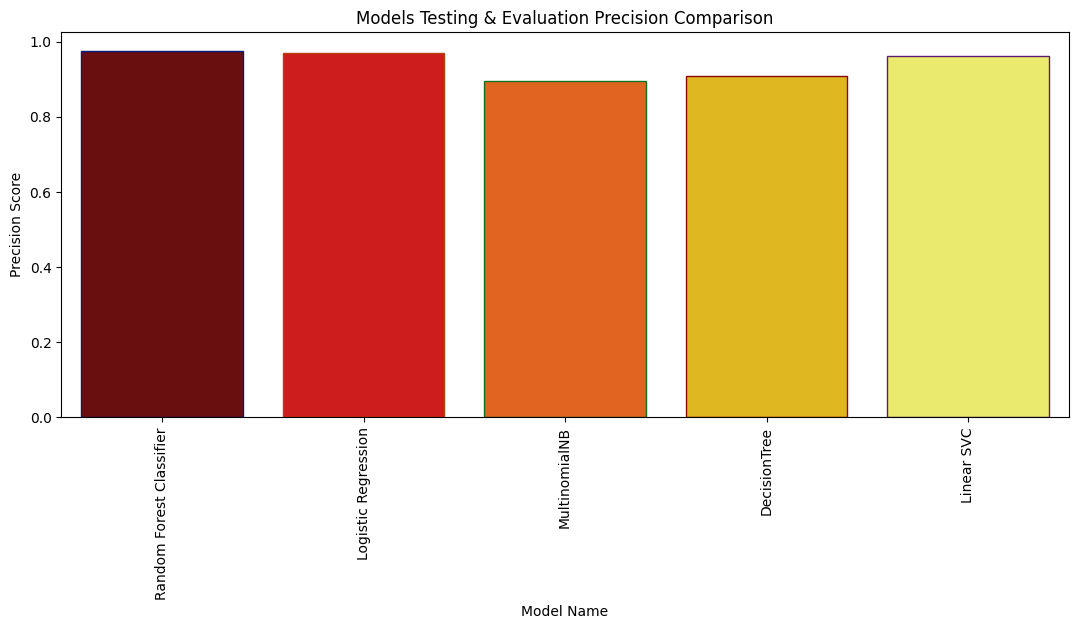

In [165]:
# Displaying a bar to compare between Models according to their Precision
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Precision Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Precision Comparison')
plt.show()

## 7.3 Comparison based on Recall

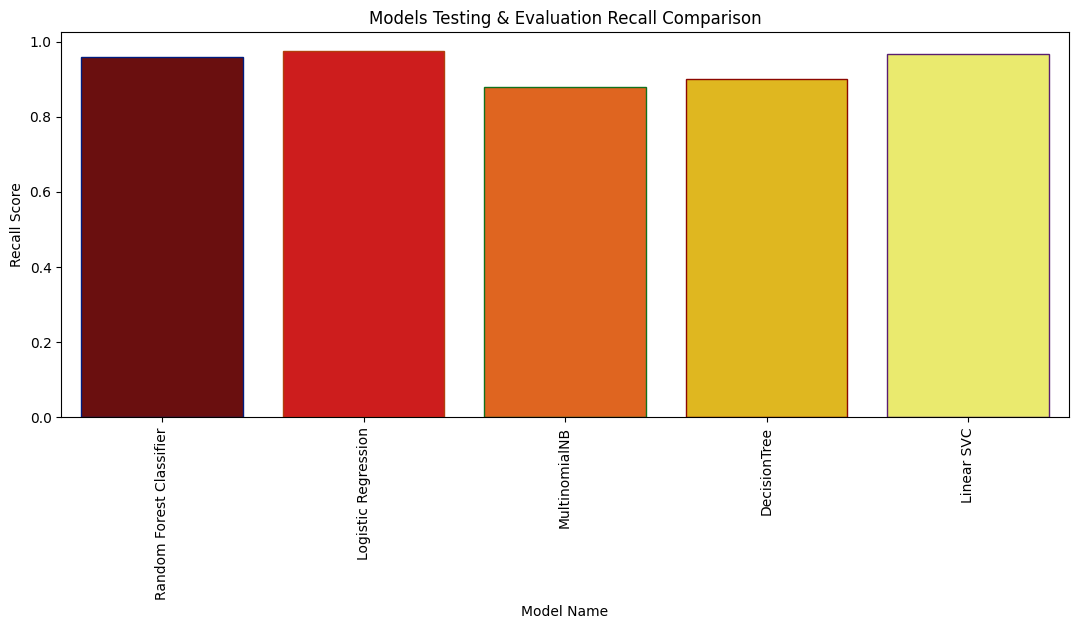

In [166]:
# Displaying a bar to compare between Models according to their Recall
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="Recall Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation Recall Comparison')
plt.show()

## 7.4 Comparison based on F1-Score

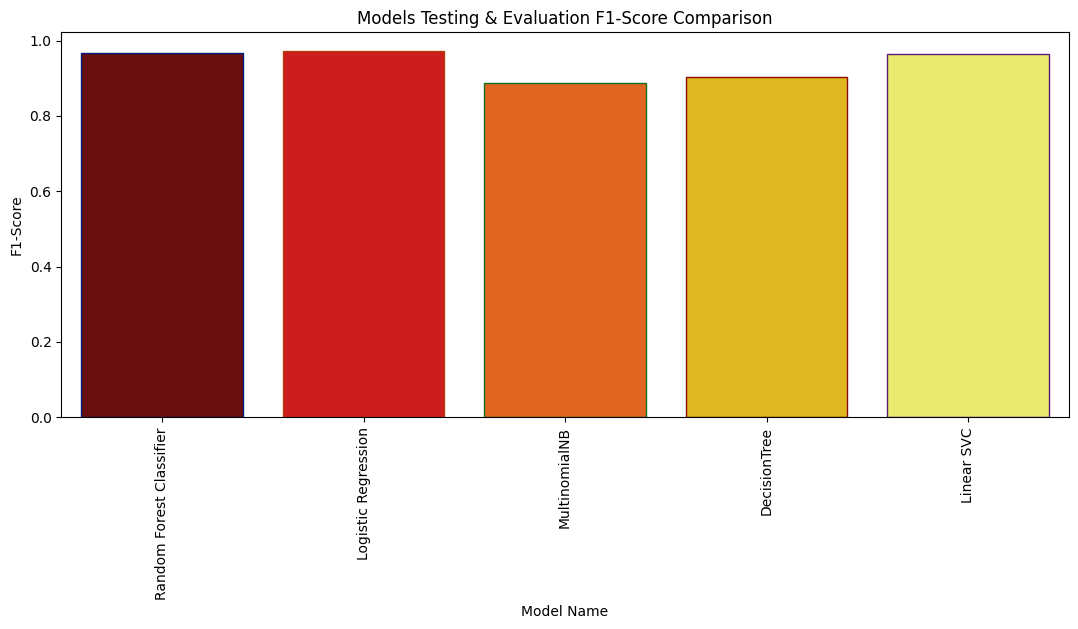

In [167]:
# Displaying a bar to compare between Models according to their F1-score
plt.subplots(figsize=(13,5))
sns.barplot(x="Model Name", y="F1-Score",data=result,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Models Testing & Evaluation F1-Score Comparison')
plt.show()

The Logistic Regression Classifier looks stable and providing the **BEST** evaluation performance, adding to its training perfromance displayed before.

So, we are on our way to use Logistic Regression Classifier for our Problem .

In [168]:
# Putting All together in Pipeline
LGR_pipe = Pipeline([('vectorizer',vectorizer),('LGR',LGR)])

# Saving the Pipeline for Later using
pickle.dump(LGR_pipe, open('LGR_Model.sav', 'wb'))

# 8. Trying & Testing

In [169]:
LGR_Model = pickle.load(open('LGR_Model.sav','rb'))           # Loading our model
Sentence = 'Kaggle is the most wonderful platforms ever !'    # The sentence to be tested

# Firstly Preprocess the sentence
lower_sen = Sentence.lower()                                  # Lowering all characters
cleaned_sentence = remove_stopwords(lower_sen)                # Removing Stop Words
tken_sentence = word_tokenize(cleaned_sentence)               # Tokenizing to be Lemmatized
lemmatized_sen = lemmatization(tken_sentence)                 # Lemmatization with POS
processed_sen = ' '.join(lemmatized_sen)                      # Regrouping

# Display the Sentence
print(processed_sen)

# Go through the Pipeline (Vectorizing & Predict)
sentiment = LGR_Model.predict([processed_sen])
if sentiment[0] == 1:
    print(Sentence, '(is Positive)')
else:
    print(Sentence, '(is Negative)')

kaggle wonderful platform !
Kaggle is the most wonderful platforms ever ! (is Positive)


It seems to be worked very well :)

# 9. Deployment

**The project is deployed Locally due lack of SpeechRecognition compatibility here in kaggle, but the final result down here is shown clearly thats everything come PERFECT !**

![](https://b.top4top.io/p_2685pepk91.jpeg)

# End Of The Notebook